# Martin Uribe

**Project repo:** [https://github.com/clamytoe/investments-vc](https://github.com/clamytoe/investments-vc)

### CareerERA Invenstment VC Capstone Project

The dataset was given to me with no instructions, no description or meaning for any of the features, and no objective to achieve. Most of the features I ended up just guessing what they meant, so hopefully I guessed right.

After having spent some time analysing this dataset I came to the conclusion that `status` was the most obvious target feature. I tried many ways to make a multi-class classifier, but the results were just not that great. After a couple of weeks at it, I made the decision to turn it into a binary classification problem. One that would classify the likelyhood of a startup company being acquired or not.

Initially the results were pretty subpar. I was averaging an accuracy of about **40%**. I tried many ways to deal with the imbalance, but the problem remained. That's when I decided to try to approach it with both downscaling and upscaling the classes. It was at this point that I started to make some meaningful achievements. 

I tried the to create a model with:

* LogisticRegression
* KNeighborsClassifier
* RandomForestClassifier
* XGBClassifier

With the initial downscaled version **XGBClassifier** was a clear winner, but when I switched to a mix of both downscale and upscale, **RandomForestClassifier** came out ahead with an accuracy of **86%** on the test dataset.

## Exploratory Data Analysis and Data Cleanup

In [1]:
from dataclasses import dataclass
import calendar
import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

from sklearn.metrics import (
    accuracy_score, auc, classification_report, f1_score, make_scorer,
    mean_squared_error, precision_score, recall_score, roc_curve,
)

warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode()

### Importing the data

The file kept returning unicode errors, so it needed special handling to load.

In [2]:
df = pd.read_csv('data/investments_VC.csv', engine='python', encoding='unicode_escape')
df.head()

permalink                name  \
0            /organization/waywire            #waywire   
1  /organization/tv-communications  &TV Communications   
2    /organization/rock-your-paper   'Rock' Your Paper   
3   /organization/in-touch-network   (In)Touch Network   
4   /organization/r-ranch-and-mine  -R- Ranch and Mine   

                    homepage_url  \
0         http://www.waywire.com   
1          http://enjoyandtv.com   
2   http://www.rockyourpaper.org   
3  http://www.InTouchNetwork.com   
4                            NaN   

                                       category_list        market   \
0         |Entertainment|Politics|Social Media|News|          News    
1                                            |Games|         Games    
2                             |Publishing|Education|    Publishing    
3  |Electronics|Guides|Coffee|Restaurants|Music|i...   Electronics    
4                      |Tourism|Entertainment|Games|       Tourism    

   funding_total_usd      status country_code state_code         region  ...  \
0          17,50,000    acquired          USA         NY  New York City  ...   
1          40,00,000   operating          USA         CA    Los Angeles  ...   
2             40,000   operating          EST        NaN        Tallinn  ...   
3          15,00,000   operating          GBR        NaN         London  ...   
4             60,000   operating          USA         TX         Dallas  ...   

  secondary_market  product_crowdfunding round_A round_B round_C  round_D  \
0              0.0                   0.0     0.0     0.0     0.0      0.0   
1              0.0                   0.0     0.0     0.0     0.0      0.0   
2              0.0                   0.0     0.0     0.0     0.0      0.0   
3              0.0                   0.0     0.0     0.0     0.0      0.0   
4              0.0                   0.0     0.0     0.0     0.0      0.0   

  round_E round_F  round_G  round_H  
0     0.0     0.0      0.0      0.0  
1     0.0     0.0      0.0      0.0  
2     0.0     0.0      0.0      0.0  
3     0.0     0.0      0.0      0.0  
4     0.0     0.0      0.0      0.0  

[5 rows x 39 columns]

### Data Cleanup

Let's explore the data further and see what we are dealing with.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [4]:
df.shape

(54294, 39)

As can be seen here, the dataset consists of 54,294 rows and 39 columns.

There's a lot of data here, let's see if there are any duplicate entries.

In [5]:
print(df.duplicated().sum())

4855


Wow, there are quite a bit of duplicate rows! Let's get rid of them.

In [6]:
df.drop_duplicates(inplace=True)
df.shape

(49439, 39)

Let's see how many null values are in the data.

In [7]:
df.isnull().sum()

permalink                   1
name                        2
homepage_url             3450
category_list            3962
 market                  3969
 funding_total_usd          1
status                   1315
country_code             5274
state_code              19278
region                   5274
city                     6117
funding_rounds              1
founded_at              10885
founded_month           10957
founded_quarter         10957
founded_year            10957
first_funding_at            1
last_funding_at             1
seed                        1
venture                     1
equity_crowdfunding         1
undisclosed                 1
convertible_note            1
debt_financing              1
angel                       1
grant                       1
private_equity              1
post_ipo_equity             1
post_ipo_debt               1
secondary_market            1
product_crowdfunding        1
round_A                     1
round_B                     1
round_C   

In [8]:
df.dropna(axis=0, how='all', inplace=True)

In [9]:
df.shape

(49438, 39)

That only got rid of one record. let's keep going.

### Column Names

Let's take a look at the column names.

In [10]:
df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', ' market ',
       ' funding_total_usd ', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

There appears to be empty spaces in some of the column names, let's clean those up.

In [11]:
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

In [12]:
df.isnull().sum()

permalink                   0
name                        1
homepage_url             3449
category_list            3961
market                   3968
funding_total_usd           0
status                   1314
country_code             5273
state_code              19277
region                   5273
city                     6116
funding_rounds              0
founded_at              10884
founded_month           10956
founded_quarter         10956
founded_year            10956
first_funding_at            0
last_funding_at             0
seed                        0
venture                     0
equity_crowdfunding         0
undisclosed                 0
convertible_note            0
debt_financing              0
angel                       0
grant                       0
private_equity              0
post_ipo_equity             0
post_ipo_debt               0
secondary_market            0
product_crowdfunding        0
round_A                     0
round_B                     0
round_C   

### Missing name

Let's take a look at the row with no name.

In [13]:
df.loc[df['name'].isnull()]

permalink name           homepage_url category_list  \
28221  /organization/tell-it-in  NaN  http://tellitin10.com    |Startups|   

           market funding_total_usd  status country_code state_code region  \
28221   Startups            25,000   closed          NaN        NaN    NaN   

       ... secondary_market  product_crowdfunding round_A round_B round_C  \
28221  ...              0.0                   0.0     0.0     0.0     0.0   

       round_D round_E round_F  round_G  round_H  
28221      0.0     0.0     0.0      0.0      0.0  

[1 rows x 39 columns]

I should be able to fill in the name from the `homepage_url`.

In [14]:
df['name'].fillna(df.iloc[28221].homepage_url.split('.')[0].replace('http://', '').title(), inplace=True)
df.dropna(subset=['permalink'], inplace=True)

### Examine the data closer

Let's take a look at the first row, to get a better sense of what each feature represents.

In [15]:
df.iloc[0]

permalink                                    /organization/waywire
name                                                      #waywire
homepage_url                                http://www.waywire.com
category_list           |Entertainment|Politics|Social Media|News|
market                                                       News 
funding_total_usd                                       17,50,000 
status                                                    acquired
country_code                                                   USA
state_code                                                      NY
region                                               New York City
city                                                      New York
funding_rounds                                                 1.0
founded_at                                              2012-06-01
founded_month                                              2012-06
founded_quarter                                            201

First thing that I noticed is the placement of those commas in the dollar amount in `funding_total_usd`. Let's clean that up.

In [16]:
df['funding_total_usd'] = df['funding_total_usd'].apply(lambda x: x.strip().replace(',', '') if isinstance(x, str) else x)
df['funding_total_usd'] = df['funding_total_usd'].apply(lambda x: 0.0 if x == '-' else float(x))

In [17]:
df.iloc[0]

permalink                                    /organization/waywire
name                                                      #waywire
homepage_url                                http://www.waywire.com
category_list           |Entertainment|Politics|Social Media|News|
market                                                       News 
funding_total_usd                                        1750000.0
status                                                    acquired
country_code                                                   USA
state_code                                                      NY
region                                               New York City
city                                                      New York
funding_rounds                                                 1.0
founded_at                                              2012-06-01
founded_month                                              2012-06
founded_quarter                                            201

### Date Fields

Let's take a closer look at the date fields.

In [18]:
df.founded_year

0        2012.0
1           NaN
2        2012.0
3        2011.0
4        2014.0
          ...  
49433    2013.0
49434       NaN
49435    2012.0
49436       NaN
49437    1999.0
Name: founded_year, Length: 49438, dtype: float64

In [19]:
df.first_funding_at

0        2012-06-30
1        2010-06-04
2        2012-08-09
3        2011-04-01
4        2014-08-17
            ...    
49433    2014-03-24
49434    2012-04-01
49435    2011-11-01
49436    2011-11-21
49437    2008-06-01
Name: first_funding_at, Length: 49438, dtype: object

In [20]:
df.founded_quarter

0        2012-Q2
1            NaN
2        2012-Q4
3        2011-Q2
4        2014-Q1
          ...   
49433    2013-Q1
49434        NaN
49435    2012-Q2
49436        NaN
49437    1999-Q1
Name: founded_quarter, Length: 49438, dtype: object

In [21]:
df.founded_month

0        2012-06
1            NaN
2        2012-10
3        2011-04
4        2014-01
          ...   
49433    2013-01
49434        NaN
49435    2012-05
49436        NaN
49437    1999-01
Name: founded_month, Length: 49438, dtype: object

In [22]:
df.founded_at

0        2012-06-01
1               NaN
2        2012-10-26
3        2011-04-01
4        2014-01-01
            ...    
49433    2013-01-28
49434           NaN
49435    2012-05-13
49436           NaN
49437    1999-01-01
Name: founded_at, Length: 49438, dtype: object

Looks like some of these could be cleaned up a bit. I also noticed that `founded_at` was mising more values than the others.

In [23]:
df['founded_month'] = pd.to_datetime(df.founded_month, format='%Y-%m').dt.to_period('M')
df['founded_quarter'] = df.founded_quarter.apply(lambda x: str(x.split('-')[1]) if isinstance(x, str) else x)
df['founded_at'] = pd.DatetimeIndex(df['founded_year']).year
df = df[df.founded_year.notna()]
df['founded_year'] = df.founded_year.astype(int)

In [24]:
df.founded_year

0        2012
2        2012
3        2011
4        2014
5        2011
         ... 
49430    1994
49432    2007
49433    2013
49435    2012
49437    1999
Name: founded_year, Length: 38482, dtype: int64

### Category List

Taking a closer look at the category list.

In [25]:
df.category_list

0               |Entertainment|Politics|Social Media|News|
2                                   |Publishing|Education|
3        |Electronics|Guides|Coffee|Restaurants|Music|i...
4                            |Tourism|Entertainment|Games|
5                                               |Software|
                               ...                        
49430                                      |Biotechnology|
49432                                      |Biotechnology|
49433    |Analytics|Gamification|Developer APIs|iOS|And...
49435        |Web Development|Advertising|Wireless|Mobile|
49437                                |Enterprise Software|
Name: category_list, Length: 38482, dtype: object

I'd like to explore what categories are more common amongst all of the startups.

In [26]:
from os import path
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

stopwords = set(STOPWORDS)
stopwords.add('nan')
# https://pixabay.com/vectors/black-black-white-dollar-sign-2029505/
mask = np.array(Image.open('img/dollar-sign.png'))

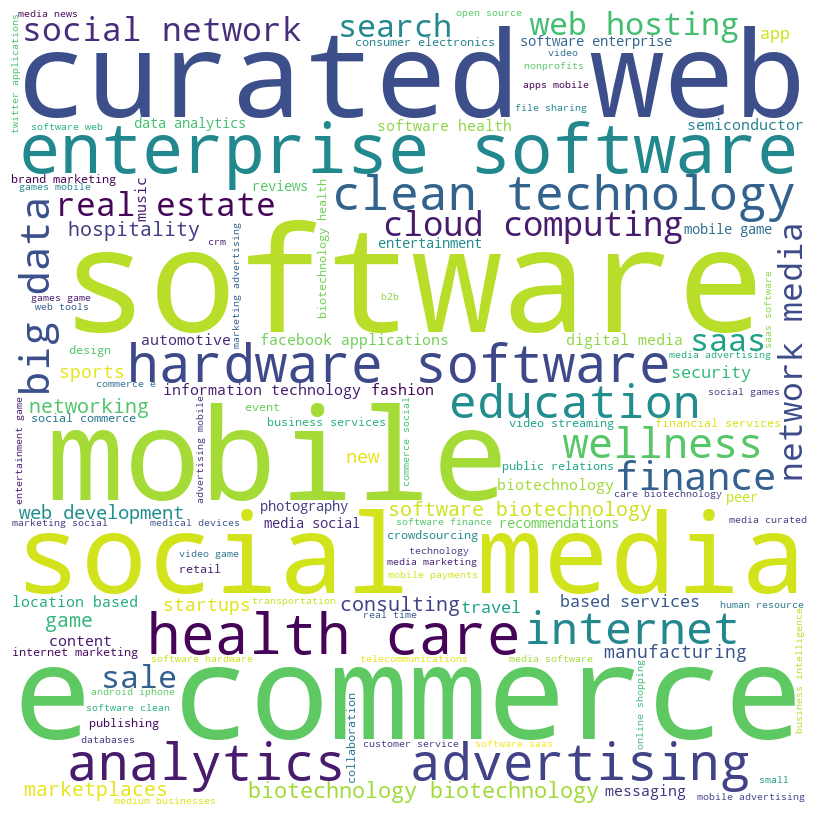

In [27]:
categories = ''
for category in df.category_list:
    category = str(category)
    tokens = category.split('|')
    tokens = [token.lower() for token in tokens]
    if len(tokens) == 2:
        if tokens[0] == tokens[1]:
            tokens = [tokens[0]]
    categories += " ".join(tokens) + " "

cwc = WordCloud(
    width=800,
    height=800,
    background_color='white',
    stopwords = stopwords,
    min_font_size=10,
).generate(categories)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cwc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

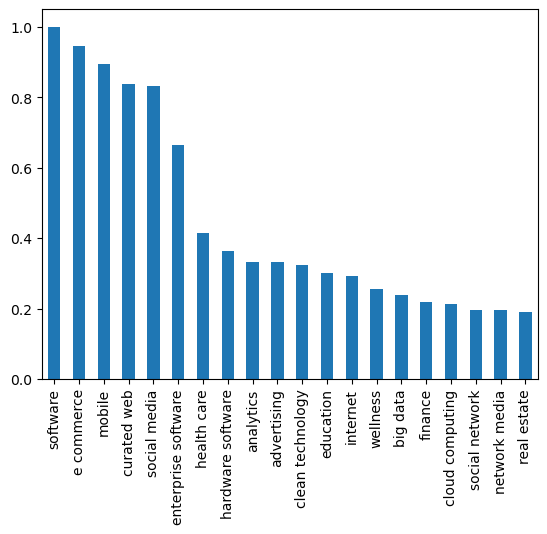

In [28]:
pd.DataFrame(cwc.words_, index=np.arange(len(cwc.words_))).iloc[0, :20].plot(kind='bar');

As can be seen here the top 5 most startup categories are:
    
* sotfware
* e-commerce
* mobile
* curated web
* social media

## Feature Engineering

Lets clean up the categories and create features from them.

In [29]:
df['category_list'] = df.category_list.apply(lambda x: str(x).lstrip('|').rstrip('|').split('|'))
df['category_list'] = df.category_list.apply(lambda x: [c.replace(' ', '_').lower() for c in x])
df['category_list'] = df.category_list.apply(lambda x: [c.strip() for c in x])

In [30]:
cat_dummies = pd.get_dummies(df.category_list.apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, cat_dummies], axis=1)
df.drop(['category_list'], axis=1, inplace=True)
df.shape

(38482, 852)

We've now gone from 39 features to 852! Let's add another feature to see how many days it took a company to get funding.

In [31]:
dt_objects = ['founded_at', 'first_funding_at', 'last_funding_at']
for d in dt_objects:
    df[d] = pd.to_datetime(df[d], errors='coerce')

In [32]:
df['days_to_funding'] = (df.first_funding_at - df.founded_at).dt.days

Let's take a closer look at `status`.

In [33]:
df.status.unique()

array(['acquired', 'operating', nan, 'closed'], dtype=object)

Intead of havign null values, let's just put them into a `pending` status for now.

In [34]:
df['status'].fillna('pending', inplace=True)

Out of all of the columns that are objects, let's see which might be better off as being considered categories.

In [35]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f'{column}: {len(df[column].unique())}')

permalink: 38481
name: 38436
homepage_url: 36266
market: 736
status: 4
country_code: 111
state_code: 62
region: 1006
city: 3636
founded_quarter: 4


Turn the smaller categorical values into categories.

In [36]:
categorical = ['market', 'status', 'country_code', 'state_code', 'founded_month', 'founded_quarter', 'founded_year']
df[categorical] = df[categorical].astype('category')

In [37]:
for column in df.columns:
    if df[column].dtype == 'category':
        print(f'{column}: {len(df[column].unique())}')

market: 736
status: 4
country_code: 111
state_code: 62
founded_month: 420
founded_quarter: 4
founded_year: 103


Let's turn these into features as well.

### Manual One-Hot-Encoding

In [38]:
def ohe(df, feature, prefix=None, drop=True):
    if prefix is None:
        dummies = pd.get_dummies(df[feature], drop_first=True)
    else:
        dummies = pd.get_dummies(df[feature], drop_first=True, prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    if drop:
        df = df.drop([feature], axis=1)
    return df

In [39]:
df['month_founded'] = df.founded_month.apply(lambda x: str(x).rsplit('-')[1])
df['month_founded'].fillna(0, inplace=True)
df['month_founded'] = df.month_founded.astype(int)
df['month_founded'] = df.month_founded.apply(lambda x: calendar.month_abbr[x])
df = df.drop(['founded_month'], axis=1)

df = ohe(df, 'month_founded', 'month')
df = ohe(df, 'founded_quarter', 'quarter', False)
df = ohe(df, 'state_code', 'state', False)
df = ohe(df, 'founded_year', 'year', False)

Let's add another to track the time between the first and last funding rounds.

In [40]:
df['funding_days'] = df.last_funding_at - df.first_funding_at
df['funding_days'] = df.funding_days.apply(lambda x: x.days)

### Get rid of null values

I found myself checking for null values quite often, so I decided to create a function for it.

In [41]:
def show_nulls(df):
    temp = df.isna().sum()
    temp = temp[temp != 0].sort_values(ascending=False)
    display(temp)

In [42]:
show_nulls(df)

state_code          13764
city                 3470
country_code         3031
region               3031
homepage_url         2139
market               1982
first_funding_at        6
days_to_funding         6
funding_days            6
last_funding_at         2
dtype: int64

In [43]:
nulls = [
    'market',
    'city',
    'days_to_funding',
    'funding_days',
]
df.dropna(subset=nulls, inplace=True)

In [44]:
show_nulls(df)

state_code      9777
homepage_url    1599
dtype: int64

Still a lot of nulls, but at this point I wasn't sure if I just wanted to dump them.

### Cleanup market names

In [45]:
df['market'] = df.market.apply(lambda x: x.strip().lower())

### Average funding total for all companies

In [46]:
avg_funding = df['funding_total_usd'].mean()
print(f"The average funding total for all companies is: ${avg_funding:,.2f}")

The average funding total for all companies is: $15,108,624.10


### Funding from each funding source

In [47]:
pd.options.display.float_format = '${:,.0f}'.format
funding_sources = [
    'seed',
    'venture',
    'equity_crowdfunding',
    'undisclosed',
    'convertible_note',
    'debt_financing',
    'angel',
    'grant',
    'private_equity',
    'post_ipo_equity',
    'post_ipo_debt',
    'secondary_market',
    'product_crowdfunding',
    'round_A',
    'round_B',
    'round_C',
    'round_D',
    'round_E',
    'round_F',
    'round_G',
    'round_H',
]
round_counts = df[funding_sources].sum()
print("Number of companies in each funding round:")
print(round_counts.sort_values(ascending=False))

Number of companies in each funding round:
venture                $302,301,966,614
private_equity          $77,347,218,961
debt_financing          $73,430,224,278
round_B                 $62,091,956,938
round_C                 $52,374,715,283
round_A                 $47,873,973,279
round_D                 $33,610,747,516
post_ipo_equity         $20,525,423,935
round_E                 $15,709,517,434
post_ipo_debt            $9,717,065,480
seed                     $8,655,835,467
round_F                  $8,057,773,291
grant                    $4,882,355,736
undisclosed              $3,074,961,995
round_G                  $2,747,816,465
angel                    $2,482,531,500
secondary_market         $1,141,071,981
convertible_note           $906,281,768
round_H                    $699,000,000
product_crowdfunding       $281,195,253
equity_crowdfunding        $214,301,662
dtype: float64


### Number of companies founded each year

In [48]:
year_counts = df['founded_year'].value_counts()
print("Number of companies founded in each year:")
print(year_counts)

Number of companies founded in each year:
2012    4382
2011    4281
2010    3286
2013    3187
2009    2653
        ... 
1941       1
1902       1
1936       0
1907       0
1905       0
Name: founded_year, Length: 103, dtype: int64


### Distribution of values in the `status`

In [49]:
print(df['status'].value_counts())

operating    28311
acquired      2747
closed        1702
pending        662
Name: status, dtype: int64


### Relationship between `funding_rounds` and `funding_total`

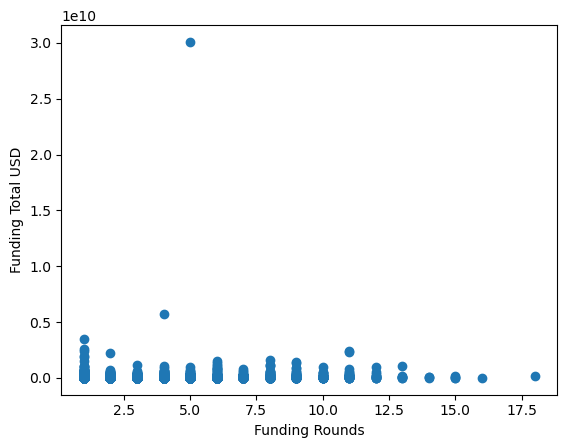

In [50]:
import matplotlib.pyplot as plt
plt.scatter(df['funding_rounds'], df['funding_total_usd'])
plt.xlabel('Funding Rounds')
plt.ylabel('Funding Total USD')
plt.show()

### Top markets

In [51]:
market_counts = df['market'].value_counts()
print("Number of companies in each market:")
print(market_counts)

Number of companies in each market:
software          3564
biotechnology     2391
mobile            1438
e-commerce        1284
curated web       1161
                  ... 
veterinary           0
china internet       0
rural energy         0
theatre              0
recreation           0
Name: market, Length: 735, dtype: int64


There's way too many to look at, let's look at the top 20.

In [52]:
top_20_markets_df = pd.DataFrame(market_counts[:20]).reset_index()
top_20_markets_df.columns = ['market', 'counts']
top_20_markets_df.head()

market  counts
0       software    3564
1  biotechnology    2391
2         mobile    1438
3     e-commerce    1284
4    curated web    1161

In [53]:
fig1 = px.bar(top_20_markets_df, x='market', y='counts', color='counts', height=600)
fig1.show()

From this graph we can clearly see which markets are the most popular across the world, with **Software** and **Biotechnology** at the forefront.

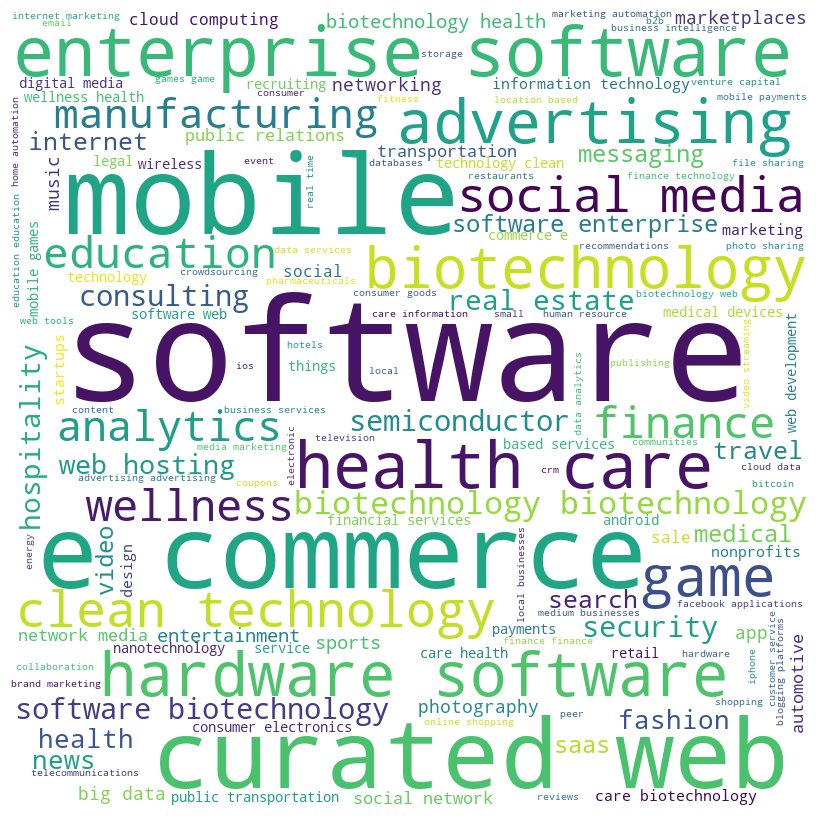

In [54]:
market_words = ''
for word in df.market:
    word = str(word)
    tokens = word.split()
    tokens = [token.lower() for token in tokens]
    if len(tokens) == 2:
        if tokens[0] == tokens[1]:
            tokens = [tokens[0]]
    market_words += " ".join(tokens) + " "

wc = WordCloud(
    width=800,
    height=800,
    background_color='white',
    stopwords = stopwords,
    min_font_size=10,
).generate(market_words)

fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
# fig.savefig('market-wordcloud.png', bbox_inches='tight', dpi=300)
plt.show()

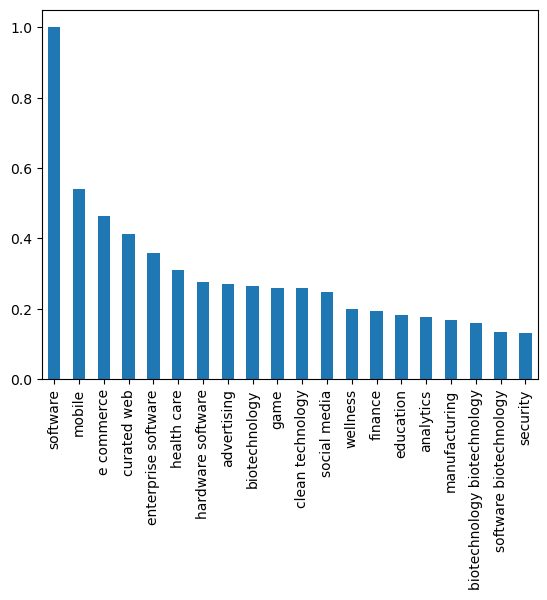

In [55]:
pd.DataFrame(wc.words_, index=np.arange(len(cwc.words_))).iloc[0, :20].plot(kind='bar');

The `category_list` differs from the `market` feature because the `category_list` can have multiple categories, while the `market` is restrained to a single value.

### Highest funded markets

In [56]:
pd.reset_option('^display.', silent=True)
markets_df = pd.DataFrame(df[['market', 'funding_total_usd']])
markets_df['funding_total_usd'].quantile([0.0, 0.25, 0.5, 0.75, 1], interpolation='nearest')

0.00    0.000000e+00
0.25    1.087000e+05
0.50    1.370000e+06
0.75    8.500000e+06
1.00    3.007950e+10
Name: funding_total_usd, dtype: float64

In [57]:
pd.options.display.float_format = '${:,.0f}'.format
markets_df['funding_total_usd'].sample(10)

4751        $40,000
16407    $2,393,500
5385     $1,971,253
45818            $0
6431             $0
21669    $3,756,836
34310       $22,864
23250      $500,000
26202   $41,000,000
37426    $4,570,000
Name: funding_total_usd, dtype: float64

In [58]:
markets_df = pd.DataFrame(df[['market', 'funding_total_usd']])

In [59]:
market_data = markets_df.groupby('market')['funding_total_usd'].sum().sort_values(ascending=False)
market_data.head()

market
biotechnology      $53,630,482,413
mobile             $45,774,651,880
software           $36,645,648,978
clean technology   $26,139,732,675
health care        $22,956,066,236
Name: funding_total_usd, dtype: float64

In [60]:
fig2 = px.bar(
    market_data[:20],
    x= market_data[:20].index,
    y='funding_total_usd',
    color='funding_total_usd',
    height=600,
    title="Top 20 Funded Markets",
    labels=dict(funding_total_usd="Funding Total ($)", x="Market"),
)
fig2.update_traces(hovertemplate='%{y:$,.2f}'),
fig2.show()

Here we can see how much funding each of the market sectors has received, with **Biotechnology** leading the pack at over $53 billion dollars.

### Highest funded companies

In [61]:
campanies_df = pd.DataFrame(df[['name', 'funding_total_usd']])
company_data = campanies_df.groupby('name')['funding_total_usd'].sum().sort_values(ascending=False)
company_data.head()

name
Verizon Communications   $30,079,503,000
Clearwire                 $5,700,000,000
First Data Corporation    $3,500,000,000
sigmacare                 $2,600,000,000
Facebook                  $2,425,700,000
Name: funding_total_usd, dtype: float64

In [62]:
fig3 = px.bar(
    company_data[:20],
    x= company_data[:20].index,
    y='funding_total_usd',
    color='funding_total_usd',
    height=600,
    title="Top 20 Funded Companies",
    labels=dict(funding_total_usd="Funding Total ($)", x="Companies"),
)
fig3.update_traces(hovertemplate='%{y:$,.2f}'),
fig3.show()

Wow, $30 billion dollars is a lot of funding going towards **Verizon Communications**!

### Startup status

In [63]:
status_df = pd.DataFrame(df['status'].value_counts())
status_df

status
operating   28311
acquired     2747
closed       1702
pending       662

In [64]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig4 = go.Figure(
    data=[
        go.Pie(
            labels=status_df.index,
            values=status_df.status,
            pull=[0.2, 0, 0, 0],
        ),
    ],
)
fig4.update_traces(
    hoverinfo='label+percent',
    textinfo='value',
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='#000000', width=1)),
)
fig4.update_layout(
    autosize=False,
    width=500,
    height=500,
)
fig4.show()

Looks like the companies that are receiving most of the funding are **operational**.

In [65]:
def generate_dfs():
    dfs = []
    for status in df.status.unique():
        tmp_df = df.query(f'status == "{status}"')
        tmp_df.attrs['name'] = status
        dfs.append(tmp_df)
    return dfs

### Startup investments in the United States by State

In [66]:
@dataclass
class Country:
    country: str
    scope: str
    locationmode:str
    title: str


def plot_map(config: Country):
    country = config.country
    scope = config.scope
    locationmode = config.locationmode
    title = config.title
    
    _df = df.query(f'country_code == "{country}"')['state_code']
    _df = _df.value_counts().to_frame()
    _df.reset_index(inplace=True)
    _df.rename(columns={'index': 'state_code', 'state_code': 'count'}, inplace=True)

    fig = go.Figure(
        data=go.Choropleth(
            locations=_df.state_code,
            z=_df['count'].astype(int),
            locationmode=locationmode,
            colorscale='darkmint',
            colorbar_title="Startup Counts",
        ),
    )
    fig.update_layout(
        title_text=title,
        geo_scope=scope,
        height=500,
    )

    fig.show()
    return _df

In [67]:
country = 'USA'
scope = country.lower()
locationmode = f'{country}-states'
title = f'{country}: Startup Investment Counts by State'
usa = Country(country, scope, locationmode, title)

usa_df = plot_map(usa)

**California** by far has the most startups at over **8k**!

### Funding by status stage

How much funding has gone into each stage for each state?

In [68]:
tmp_df = df.query('country_code == "USA"')[['state_code', 'status', 'funding_total_usd']]
state_funding_df = tmp_df.groupby(['state_code', 'status'])['funding_total_usd'].sum().to_frame()
state_funding_df.reset_index(inplace=True)

fig5 = px.treemap(
    state_funding_df,
    path=[px.Constant("USA"), 'state_code', 'status'],
    values='funding_total_usd',
    title='USA: States with the most funding',
    height=600,
)
fig5.update_traces(
    hovertemplate='<b>%{label}</b> <br> Funding: %{value:$,.2f}'),
fig5.show()

Interesting insight here is that **Washington's** *operating* startups are almost the same as its *acquired* ones.

### Funding rounds

Let's take a look at how many rounds of funding each of the stages received.

In [69]:
funding_rounds_df = df.groupby(['status', 'funding_rounds'])['name'].count().to_frame()
funding_rounds_df.rename(columns={'name': 'count'}, inplace=True)
funding_rounds_df.reset_index(inplace=True)

fig6 = px.bar(
    funding_rounds_df,
    x='status',
    y='count',
    color='funding_rounds',
    hover_data=['funding_rounds'],
    barmode='stack',
)
fig6.update_layout(height=600, width=800, title='Funding Rounds by Status')

fig6.show()

It's obvious now that the startups that are still operational are the ones that receive the most rounds of funding.

### Year that most startups were founded on

The data goes back pretty far and no significant changes are visible until the late 90's, so I've filtered out the older stuff.

In [70]:
newer_df = df[df.founded_year.astype(int) > 1990]
founded_counts = newer_df.groupby('founded_year')['name'].count().to_frame().reset_index()
# founded_counts.plot(x='year')
fig7 = px.line(founded_counts, x='founded_year', y='name')
fig7.update_traces(hovertemplate=None)
fig7.update_layout(
    xaxis_title='year',
    yaxis_title='startup count',
    height=600,
    width=600,
    title='Startup Count by Year',
    hovermode="x",
)
fig7.show()

The year **2012** was the year for startups, with **4,382**! It's been declining ever since.

### Startup Count by Quarter

In [71]:
founded_qcounts = newer_df.groupby('founded_quarter')['name'].count().to_frame().reset_index()

fig8 = px.bar(founded_qcounts, x='founded_quarter', y='name')
fig8.update_traces(hovertemplate=None)
fig8.update_layout(
    xaxis_title='year quarter',
    yaxis_title='startup count',
    height=600,
    width=800,
    title='Startup Count by Quarter per Year',
    hovermode="x",
)
fig8.show()

It's pretty interesting to see that the most startups are founded on the first quarter of each year.

### Startups that got funding within the first year

Here's the top 20 companies that received the most funding within the first year.

In [72]:
pd.reset_option('^display.', silent=True)
under_one_df = newer_df[(newer_df.funding_days > 0) & (newer_df.funding_days < 365) & (newer_df['funding_total_usd'] > 0)]
under_one_df = under_one_df[['name', 'market', 'funding_total_usd', 'status', 'country_code', 'funding_days']]
under_one_df.dropna(subset=['market', 'country_code'], inplace=True)
under_one_df.sort_values(by=['funding_days', 'funding_total_usd'], ascending=[True, False], inplace=True)
under_one_df.reset_index(drop=True, inplace=True)
under_one_df.head(20)

name                market  funding_total_usd  \
0   NorthStar Systems International              software         29500000.0   
1                          Levicept         biotechnology         19913173.0   
2                     D3 Technology    financial services         14000000.0   
3                           HiWired              software         14000000.0   
4                          dloHaiti      clean technology          6769900.0   
5                            Scopix                retail          5642292.0   
6    E-Health Records International   health and wellness          3043610.0   
7                    Eagle Genomics         biotechnology          2136504.0   
8                             Hatch    mass customization          1650000.0   
9        Pinnacle Medical Solutions           health care          1500000.0   
10              One Exchange Street  e-commerce platforms          1000000.0   
11                        Sendmebox            e-commerce           328571.0   
12     Nitinol Devices & Components           health care         40000000.0   
13                       U4iA Games                mobile          7030928.0   
14               Kilimanjaro Energy      clean technology          3150000.0   
15                 Caustic Graphics   hardware + software          3099200.0   
16                      Motion Math                 games           500000.0   
17                          Otogami           video games           450000.0   
18                          trinket             education           425000.0   
19                         Winerist            technology           360000.0   

       status country_code  funding_days  
0    acquired          USA           1.0  
1   operating          GBR           1.0  
2   operating          USA           1.0  
3    acquired          USA           1.0  
4   operating          USA           1.0  
5   operating          USA           1.0  
6   operating          USA           1.0  
7   operating          GBR           1.0  
8   operating          USA           1.0  
9   operating          USA           1.0  
10  operating          USA           1.0  
11  operating          RUS           1.0  
12    pending          USA           2.0  
13  operating          USA           2.0  
14  operating          USA           2.0  
15  operating          USA           2.0  
16  operating          USA           2.0  
17  operating          ESP           2.0  
18  operating          USA           2.0  
19  operating          USA           2.0

### Starup count by quarter per year

In [73]:
fig9 = px.scatter_geo(
    under_one_df,
    locations='country_code',
    color='country_code',
    hover_name='country_code',
    # size='funding_total_usd',
    animation_frame='funding_days',
    projection='mercator',
    # projection='natural earth2',
    # projection='orthographic',
    hover_data={
        'country_code': False,
        'funding_total_usd': ':$,.0f',
        'funding_days': ':,0f',
    },
)
fig9.update_layout(
    height=600,
    width=800,
    title='Startup Count by Quarter per Year',
)
fig9.show()

## Let's revisit those null values

In [74]:
show_nulls(df)

state_code      9777
homepage_url    1599
dtype: int64

In [75]:
nonull_df = df.drop(['homepage_url', 'state_code'], axis=1)
show_nulls(nonull_df)

Series([], dtype: int64)

Let's create lists of the numeric and categorical features.

In [76]:
numeric = [feature for feature in nonull_df.columns if nonull_df[feature].dtype == 'float']
categorical = [feature for feature in nonull_df.columns if nonull_df[feature].dtype != 'float']

Another look at the target feature.

<AxesSubplot: xlabel='status', ylabel='Count'>

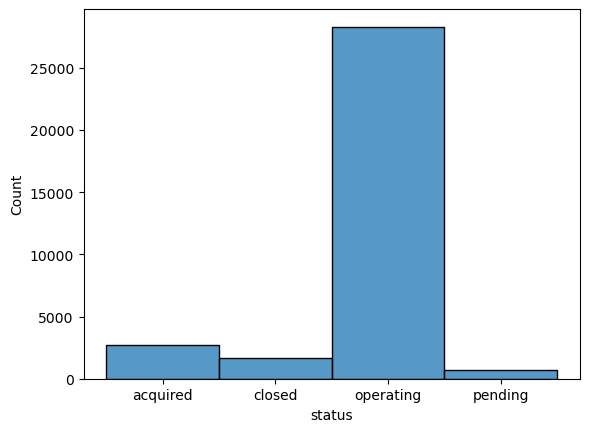

In [77]:
sns.histplot(nonull_df, x='status')

In [78]:
nonull_df.groupby('status')['status'].count()

status
acquired      2747
closed        1702
operating    28311
pending        662
Name: status, dtype: int64

> Since `status` is my target variable, I'm going to try and predict which startups get acquired, so here I'm going to change this feature into binary for easier classification.

In [79]:
status_values = {
    'acquired': 1,
    'operating': 0,
    'pending': 0,
    'closed': 0,
}
nonull_df['status'] = nonull_df.status.map(status_values)
nonull_df.status.value_counts()

0    30675
1     2747
Name: status, dtype: int64

### Visualize the imbalance of the target classes

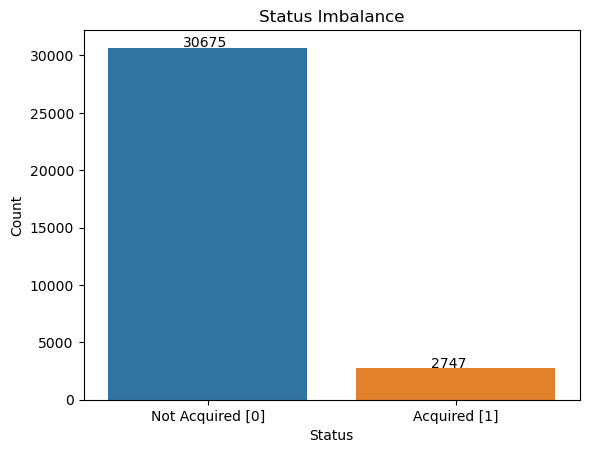

In [80]:
ax = sns.countplot(data=nonull_df, x='status')
ax.set(xlabel='Status', ylabel='Count', title='Status Imbalance', xticklabels=['Not Acquired [0]', 'Acquired [1]'])

for patch in ax.patches:
    ax.annotate(f'{int(patch.get_height())}', (patch.get_x() + 0.3, patch.get_height() + 50))

### Category frequencies

Now that I have a dataset with no null values, I wanted to revisit the category list to see if it changed any.

In [81]:
category_frequencies = []
column_names = cat_dummies.columns.to_list()
for name in column_names:
    cat = {'frequency': nonull_df[name].sum(), 'category': name}
    category_frequencies.append(cat)

category_frequencies = sorted(category_frequencies, key=lambda x: x['frequency'], reverse=True)

In [82]:
X = []
y = []
for cat in category_frequencies[:20]:
    X.append(cat['category'])
    y.append(cat['frequency'])

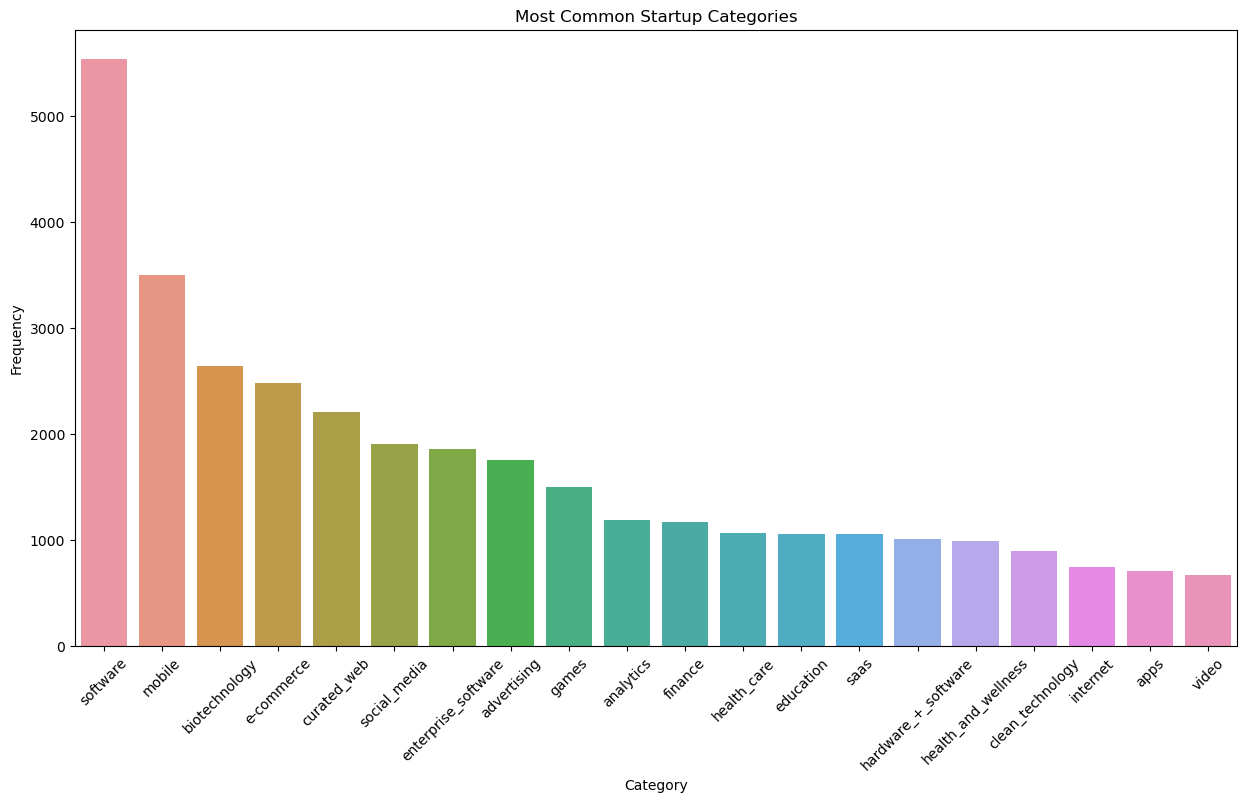

In [83]:
fig10, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x=X, y=y)
ax.set(xlabel='Category', ylabel='Frequency', title='Most Common Startup Categories')
plt.xticks(rotation=45)
plt.show()

It stayed the same for the most part.

### Funding sources for aquired startups

In [84]:
funding_types = [
    'seed',
    'venture',
    'equity_crowdfunding',
    'undisclosed',
    'convertible_note',
    'debt_financing',
    'angel',
    'grant',
    'private_equity',
    'post_ipo_equity',
    'post_ipo_debt',
    'secondary_market',
    'product_crowdfunding',
    'round_A',
    'round_B',
    'round_C',
    'round_D',
    'round_E',
    'round_F',
    'round_G',
    'round_H',
]
acquired = nonull_df[nonull_df.status == 1]
funds = [acquired[fund].sum() for fund in funding_types]
dollars = [f'${f:,.2f}' for f in funds]

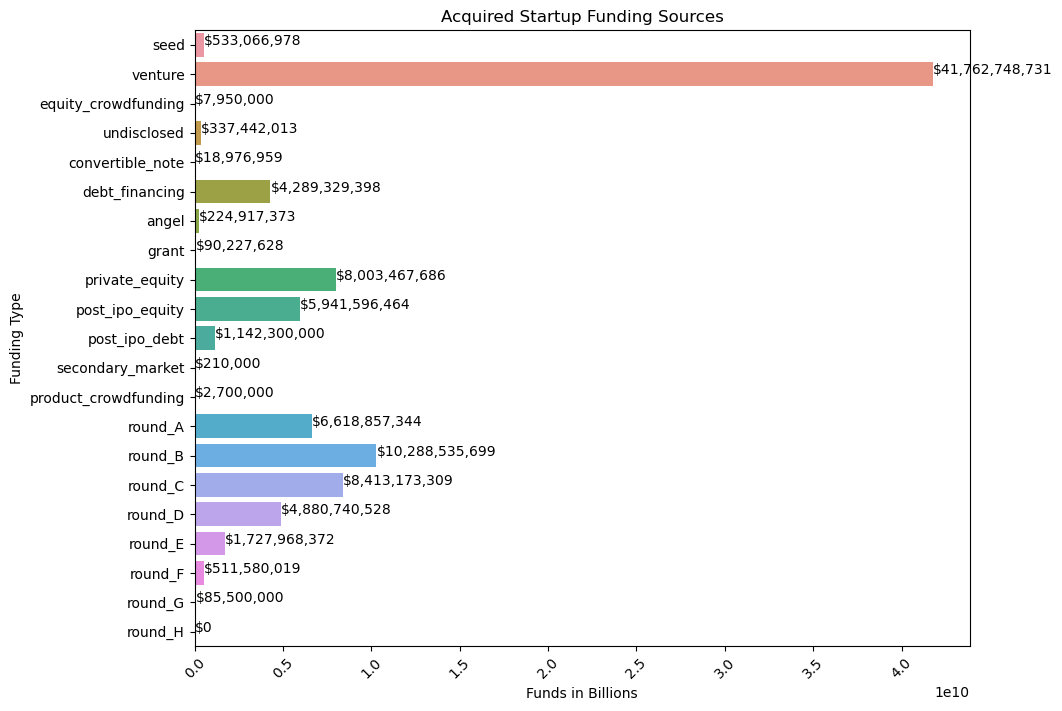

In [85]:
fig11, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x=funds, y=funding_types, orient='h')
ax.set(xlabel='Funds in Billions', ylabel='Funding Type', title='Acquired Startup Funding Sources')

for patch in ax.patches:
    _x = patch.get_x() + patch.get_width()
    _y = patch.get_y() + patch.get_height() / 2
    value = f'${patch.get_width():,.0f}'
    ax.text(_x, _y, value, ha='left')

plt.xticks(rotation=45)
plt.show()

With this being a VC dataset, it's no surprise that most of the funding for startup companies comes from venture capitalists.

## Prepare data for modeling

In [86]:
import joblib

import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.utils import parallel_backend, resample

## Train, Test, Val Split + Feature scaling + OHE

Remove features that we don't need.

In [87]:
remove_cat = [
    'permalink',
    'status',
    'founded_at',
    'first_funding_at',
    'last_funding_at',
]
for feature in remove_cat:
    categorical.remove(feature)

Create train, val, test splits.

In [88]:
df_train_full, df_test = train_test_split(nonull_df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.status.values
y_val = df_val.status.values
y_test = df_test.status.values

del df_train['status']
del df_val['status']
del df_test['status']

Scale the numeric featuers and one hot encode the categorical ones.

In [89]:
# scale the numeric features
scaler = StandardScaler()

X_train_num = df_train[numeric].values
X_train_num = scaler.fit_transform(X_train_num)

# one hot encode categorical featuers
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_train_cat = ohe.fit_transform(df_train[categorical].values)
X_train = np.column_stack([X_train_num, X_train_cat])

## Score Keeper DataFrame and Function

I like to use this to keep track of my classifiers and their metrics.

In [90]:
columns = ['classifier', 'accuracy', 'precision', 'recall', 'f1-score']
clf_scores = pd.DataFrame(columns=columns)


def score_keeper(clf, y_true, y_pred):
    global clf_scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    scores = {
        'classifier': clf,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
    }
    clf_scores = clf_scores.append(scores, ignore_index=True)

## Baseline Logistic Regression Classifier

In [91]:
baseline = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
baseline.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [92]:
X_val_num = df_val[numeric].values
X_val_num = scaler.transform(X_val_num)

X_val_cat = ohe.transform(df_val[categorical].values)
X_val = np.column_stack([X_val_num, X_val_cat])

y_pred = baseline.predict(X_val)
score_keeper('BaseLine-LR', y_val, y_pred)
clf_scores[clf_scores.classifier == 'BaseLine-LR']

classifier  accuracy  precision    recall  f1-score
0  BaseLine-LR  0.913538     0.6276  0.531497  0.539383

## Handle class imbalance

Wow, **91%** accuracy! 

Not so fast. With the target variable being so imbalanced, this metric is very deceiving. 

Let's try and handle the class imbalance in two ways. First I will downsample the not acquired records to match the acquired ones. Then I will upscale the acquired ones to 5000 and downsample the not acquired ones to the same amount. 

At the end, I will compare all of the models and chose the best one out of them.

## Downsampled Dataset

In [93]:
a_down = nonull_df[nonull_df.status == 1]
na_down = nonull_df[nonull_df.status == 0]
na_downsampled = resample(
    na_down,
    replace=True,
    n_samples = len(a_down),
    random_state=42,
)
down_df = pd.concat([a_down, na_downsampled])
down_df.status.value_counts()

1    2747
0    2747
Name: status, dtype: int64

### Train, Validation, and Test Set Split Function

Since I was going to be doing this a couple of times, I decided to put it into a function.

In [94]:
def ds_splits(df, categorical, numeric):
    # create train, test, val splits
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.status.values
    y_val = df_val.status.values
    y_test = df_test.status.values

    del df_train['status']
    del df_val['status']
    del df_test['status']

    # scale the numeric features
    scaler = StandardScaler()

    X_train_num = df_train[numeric].values
    X_train_num = scaler.fit_transform(X_train_num)

    X_val_num = df_val[numeric].values
    X_val_num = scaler.transform(X_val_num)

    X_test_num = df_test[numeric].values
    X_test_num = scaler.transform(X_test_num)

    # one hot encode categorical featuers
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

    X_train_cat = ohe.fit_transform(df_train[categorical].values)
    X_train = np.column_stack([X_train_num, X_train_cat])

    X_val_cat = ohe.transform(df_val[categorical].values)
    X_val = np.column_stack([X_val_num, X_val_cat])

    X_test_cat = ohe.transform(df_test[categorical].values)
    X_test = np.column_stack([X_test_num, X_test_cat])
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [95]:
X_train_d, X_val_d, X_test_d, y_train_d, y_val_d, y_test_d = ds_splits(down_df, categorical, numeric)

### Gridsearch Function

In [96]:
def grid_search(X, y, param_grid, cv, estimator):
    gs = GridSearchCV(estimator, param_grid, cv=cv, n_jobs=-1)
    with parallel_backend('threading'):
        gs.fit(X, y)
    return gs

> **NOTE:** Since training takes time, I commented out the GridSearchCV portions of the notebook and just added print statements to match the results that I received from each training session.

## Logistic Regression - Downsampled

In [97]:
# estimator = LogisticRegression()
# param_grid = {
#     'solver': ['lbfgs', 'saga'],
#     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100],
#     'penalty': ['elasticnet'],
#     'max_iter': [100, 200, 300],
#     'l1_ratio': [0.1, 0.2, 0.3],
# }
# lr_gs = grid_search(X_train_d, y_train_d, param_grid, 3, estimator)

# print("Best parameters: ", lr_gs.best_params_)
# print("Best accuracy: ", lr_gs.best_score_)

print("Best parameters:  {'C': 100, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}")
print("Best accuracy:  0.7477166844587358")

Best parameters:  {'C': 100, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
Best accuracy:  0.7477166844587358


In [98]:
lr_model = LogisticRegression(
    C=100,
    l1_ratio=0.1,
    max_iter=100,
    penalty='elasticnet',
    solver='saga',
)
lr_model.fit(X_train_d, y_train_d)

LogisticRegression(C=100, l1_ratio=0.1, penalty='elasticnet', solver='saga')

In [99]:
y_pred = lr_model.predict(X_val_d)
score_keeper('LogisticRegression', y_val_d, y_pred)
clf_scores[clf_scores.classifier == 'LogisticRegression']

classifier  accuracy  precision    recall  f1-score
1  LogisticRegression  0.768881   0.768978  0.768967  0.768881

## KNeighborsClassifier - Downsampled

In [100]:
# estimator = KNeighborsClassifier()
# param_grid = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}

# knn_gs = grid_search(X_train_d, y_train_d, param_grid, 5, estimator)

# print("Best parameters: ", knn_gs.best_params_)
# print("Best accuracy: ", knn_gs.best_score_)

print("Best parameters:  {'n_neighbors': 5, 'weights': 'distance'}")
print("Best accuracy:  0.6937677217336093")

Best parameters:  {'n_neighbors': 5, 'weights': 'distance'}
Best accuracy:  0.6937677217336093


In [101]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train_d, y_train_d)

KNeighborsClassifier(weights='distance')

In [102]:
y_pred = knn_model.predict(X_val_d)
score_keeper('KNeighborsClassifier', y_val_d, y_pred)
clf_scores[clf_scores.classifier == 'KNeighborsClassifier']

classifier  accuracy  precision    recall  f1-score
2  KNeighborsClassifier  0.708826   0.709555  0.709089   0.70872

## Random Forest - Downsampled

In [103]:
# estimator = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
# }
# rf_gs = grid_search(X_train_d, y_train_d, param_grid, 5, estimator)

# print("Best parameters: ", rf_gs.best_params_)
# print("Best accuracy: ", rf_gs.best_score_)

print("Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}")
print("Best accuracy:  0.7492399044739937")

Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy:  0.7492399044739937


In [104]:
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
rf_model.fit(X_train_d, y_train_d)

RandomForestClassifier()

In [105]:
y_pred = rf_model.predict(X_val_d)
score_keeper('RandomForestClassifier', y_val_d, y_pred)
clf_scores[clf_scores.classifier == 'RandomForestClassifier']

classifier  accuracy  precision   recall  f1-score
3  RandomForestClassifier   0.77525   0.776077  0.77551  0.775176

## XGBoost - Downsampled

In [106]:
# estimator = xgb.XGBClassifier()
# param_grid = {
#     'nthread': [4],
#     'objective': ['binary:logistic'],
#     'learning_rate': [0.05],
#     'max_depth': [3, 4, 5, 6],
#     'min_child_weight': [11],
#     'subsample': [0.8],
#     'colsample_bytree': [0.7],
#     'n_estimators': [5, 100, 200, 300, 500], #number of trees, change it to 1000 for better results
#     'missing': [-999],
#     'seed': [42],
# }
# cv = cv=StratifiedKFold(shuffle=True, random_state=42)
# xgb_gs = grid_search(X_train_d, y_train_d, param_grid, cv, estimator)

# print("Best parameters: ", xgb_gs.best_params_)
# print("Best accuracy: ", xgb_gs.best_score_)

# GridSearchCV(
#     xgb_clf,
#     param_grid,
#     n_jobs=5, 
#     cv=StratifiedKFold(
#         shuffle=True,
#         random_state=42,
#     ),
#     scoring='roc_auc',
#     verbose=2,
#     refit=True,
# )
# with parallel_backend('threading'):
#     grid_search.fit(X_train_d, y_train_d)

print("Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 300, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.8}")
print("Best accuracy:  0.7682433748674252")

Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 300, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.8}
Best accuracy:  0.7682433748674252


In [107]:
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=11,
    missing=-999,
    n_estimators=300,
    nthread=4,
    objective='binary:logistic',
    seed=42,
    subsample=0.8,
    n_jobs=-1,
)
xgb_model.fit(X_train_d, y_train_d)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=11, missing=-999,
              monotone_constraints='()', n_estimators=300, n_jobs=-1, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

In [108]:
y_pred = xgb_model.predict(X_val_d)
score_keeper('XGBoost', y_val_d, y_pred)
clf_scores[clf_scores.classifier == 'XGBoost']

classifier  accuracy  precision    recall  f1-score
4    XGBoost   0.77798   0.778652  0.778213  0.777927

## Compare the different models

In [109]:
clf_scores

classifier  accuracy  precision    recall  f1-score
0             BaseLine-LR  0.913538   0.627600  0.531497  0.539383
1      LogisticRegression  0.768881   0.768978  0.768967  0.768881
2    KNeighborsClassifier  0.708826   0.709555  0.709089  0.708720
3  RandomForestClassifier  0.775250   0.776077  0.775510  0.775176
4                 XGBoost  0.777980   0.778652  0.778213  0.777927

So far, with the downsampled dataset, the clearwiner is XGBoost. Now let's see what combined up and down sampled dataset will yield.

## Upsampled Dataset

In [110]:
# upsample acquired
a_up = nonull_df[nonull_df.status == 1]
na_up = nonull_df[nonull_df.status == 0]
a_upsampled = resample(
    a_up,
    replace=True,
    n_samples=5_000,
    random_state=42,
)
up_df = pd.concat([na_up, a_upsampled])
up_df.status.value_counts()

0    30675
1     5000
Name: status, dtype: int64

In [111]:
# downsample not acquired
na_ud = up_df[up_df.status == 0]
a_ud = up_df[up_df.status == 1]
na_downsampled = resample(
    na_ud,
    replace=True,
    n_samples=5_000,
    random_state=42,
)
ud_df = pd.concat([a_ud, na_downsampled])
ud_df.status.value_counts()

1    5000
0    5000
Name: status, dtype: int64

### Train, val, test split

In [112]:
X_train_u, X_val_u, X_test_u, y_train_u, y_val_u, y_test_u = ds_splits(ud_df, categorical, numeric)

## LogisticRegression - Upsampled

In [113]:
# estimator = LogisticRegression()
# param_grid = {
#     'solver': ['lbfgs', 'saga'],
#     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100],
#     'penalty': ['elasticnet'],
#     'max_iter': [100, 200, 300],
#     'l1_ratio': [0.1, 0.2, 0.3],
# }
# lr_gs_u = grid_search(X_train_u, y_train_u, param_grid, 3, estimator)

# print("Best parameters: ", lr_gs_u.best_params_)
# print("Best accuracy: ", lr_gs_u.best_score_)

print("Best parameters:  {'C': 10, 'l1_ratio': 0.1, 'max_iter': 300, 'penalty': 'elasticnet', 'solver': 'saga'}")
print("Best accuracy:  0.7686666666666667")

Best parameters:  {'C': 10, 'l1_ratio': 0.1, 'max_iter': 300, 'penalty': 'elasticnet', 'solver': 'saga'}
Best accuracy:  0.7686666666666667


In [114]:
lru_model = LogisticRegression(
    C=10,
    l1_ratio=0.1,
    max_iter=300,
    penalty='elasticnet',
    solver='saga',
)
lru_model.fit(X_train_u, y_train_u)

LogisticRegression(C=10, l1_ratio=0.1, max_iter=300, penalty='elasticnet',
                   solver='saga')

In [115]:
# y_pred = lru_model.best_estimator_.predict(X_val_u)
y_pred = lru_model.predict(X_val_u)
score_keeper('LogisticRegression^', y_val_u, y_pred)
clf_scores[clf_scores.classifier == 'LogisticRegression^']

classifier  accuracy  precision    recall  f1-score
5  LogisticRegression^      0.77   0.770053  0.769993  0.769985

## KNeighborsClassifier - Upsampled

In [116]:
# estimator = KNeighborsClassifier()
# param_grid = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}

# knnu_gs = grid_search(X_train_u, y_train_u, param_grid, 5, estimator)

# print("Best parameters: ", knnu_gs.best_params_)
# print("Best accuracy: ", knnu_gs.best_score_)

print("Best parameters:  {'n_neighbors': 4, 'weights': 'distance'}")
print("Best accuracy:  0.7865000000000001")

Best parameters:  {'n_neighbors': 4, 'weights': 'distance'}
Best accuracy:  0.7865000000000001


In [117]:
knnu_model = KNeighborsClassifier(n_neighbors=4, weights='distance')
knnu_model.fit(X_train_u, y_train_u)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [118]:
y_pred = knnu_model.predict(X_val_u)
score_keeper('KNeighborsClassifier^', y_val_u, y_pred)
clf_scores[clf_scores.classifier == 'KNeighborsClassifier^']

classifier  accuracy  precision    recall  f1-score
6  KNeighborsClassifier^    0.7975   0.804648  0.797423  0.796276

## RandomForest - Upsampled

In [119]:
# estimator = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
# }
# rfu_gs = grid_search(X_train_u, y_train_u, param_grid, 5, estimator)

# print("Best parameters: ", rfu_gs.best_params_)
# print("Best accuracy: ", rfu_gs.best_score_)

print("Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}")
print("Best accuracy:  0.8351666666666666")

Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy:  0.8351666666666666


In [120]:
rfu_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
rfu_model.fit(X_train_u, y_train_u)

RandomForestClassifier()

In [121]:
y_pred = rfu_model.predict(X_val_u)
score_keeper('RandomForestClassifier^', y_val_u, y_pred)
clf_scores[clf_scores.classifier == 'RandomForestClassifier^']

classifier  accuracy  precision    recall  f1-score
7  RandomForestClassifier^     0.847   0.848822  0.846964   0.84679

## XGBoost - Upsampled

In [122]:
# estimator = xgb.XGBClassifier()
# param_grid = {
#     'nthread': [4],
#     'objective': ['binary:logistic'],
#     'learning_rate': [0.05],
#     'max_depth': [3, 4, 5, 6],
#     'min_child_weight': [11],
#     'subsample': [0.8],
#     'colsample_bytree': [0.7],
#     'n_estimators': [5, 100, 200, 300, 500], #number of trees, change it to 1000 for better results
#     'missing': [-999],
#     'seed': [42],
# }
# cv = cv=StratifiedKFold(shuffle=True, random_state=42)
# xgbu_gs = grid_search(X_train_u, y_train_u, param_grid, cv, estimator)

# print("Best parameters: ", xgbu_gs.best_params_)
# print("Best accuracy: ", xgbu_gs.best_score_)

print("Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 500, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.8}")
print("Best accuracy:  0.8085000000000001")

Best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 500, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.8}
Best accuracy:  0.8085000000000001


In [123]:
xgbu_model = xgb.XGBClassifier(
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=11,
    missing=-999,
    n_estimators=500,
    nthread=4,
    objective='binary:logistic',
    seed=42,
    subsample=0.8,
    n_jobs=-1,
)
xgbu_model.fit(X_train_u, y_train_u)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=11, missing=-999,
              monotone_constraints='()', n_estimators=500, n_jobs=-1, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

In [124]:
y_pred = xgbu_model.predict(X_val_u)
score_keeper('XGBoost^', y_val_u, y_pred)
clf_scores[clf_scores.classifier == 'XGBoost^']

classifier  accuracy  precision    recall  f1-score
8   XGBoost^     0.798   0.798236  0.797986  0.797955

## Results

Compare all the models with their metrics.

In [125]:
clf_scores

classifier  accuracy  precision    recall  f1-score
0              BaseLine-LR  0.913538   0.627600  0.531497  0.539383
1       LogisticRegression  0.768881   0.768978  0.768967  0.768881
2     KNeighborsClassifier  0.708826   0.709555  0.709089  0.708720
3   RandomForestClassifier  0.775250   0.776077  0.775510  0.775176
4                  XGBoost  0.777980   0.778652  0.778213  0.777927
5      LogisticRegression^  0.770000   0.770053  0.769993  0.769985
6    KNeighborsClassifier^  0.797500   0.804648  0.797423  0.796276
7  RandomForestClassifier^  0.847000   0.848822  0.846964  0.846790
8                 XGBoost^  0.798000   0.798236  0.797986  0.797955

It looks like the **upsampled dataset** along with **RandomForestClassifier** produces the best results.

## Test Set Validation

Now let's see how it does with the test set that we set aside at the beginning of this journey.

In [126]:
test_probs = rfu_model.predict_proba(X_test_u)[:, 1]
y_pred_class = np.where(test_probs > 0.5, 1, 0)

In [127]:
print(classification_report(y_test_u, y_pred_class))

              precision    recall  f1-score   support

           0       0.90      0.82      0.85       988
           1       0.84      0.91      0.87      1012

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



In [128]:
confusion_matrix(y_test_u, y_pred_class)

array([[807, 181],
       [ 94, 918]])

There you go, the test set did even better than the validation set, achieving an **86%** accuracy. It's generalizing the data pretty well.

In [129]:
nonull_df.shape

(33422, 1027)

## Conclusion

These are all of the tasks that I set out to do:

- [X] Cleaned up the data
- [X] Analyzed the data
- [X] Extracted some meaningful insights from the data
- [X] Feature engineered 988 new features
- [X] Successfully handled the imbalance of the target classes
- [X] Performed some extensive model tuning to find optimal parameters
- [X] Selected the best model
- [X] Saved the model for deployment
- [X] Create python script to prepare the data
- [X] Create python script to create and save the model
- [ ] Deploy the model with FastAPI and gunicorn or Flask and nginx
- [ ] Containerize the model with Docker
- [ ] Deploy the model on the cloud

I the end, I just ran out of time but since the last items on my todo list have not been covered in the classes yet, I think I can be forgiven.